In [15]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from random import random
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

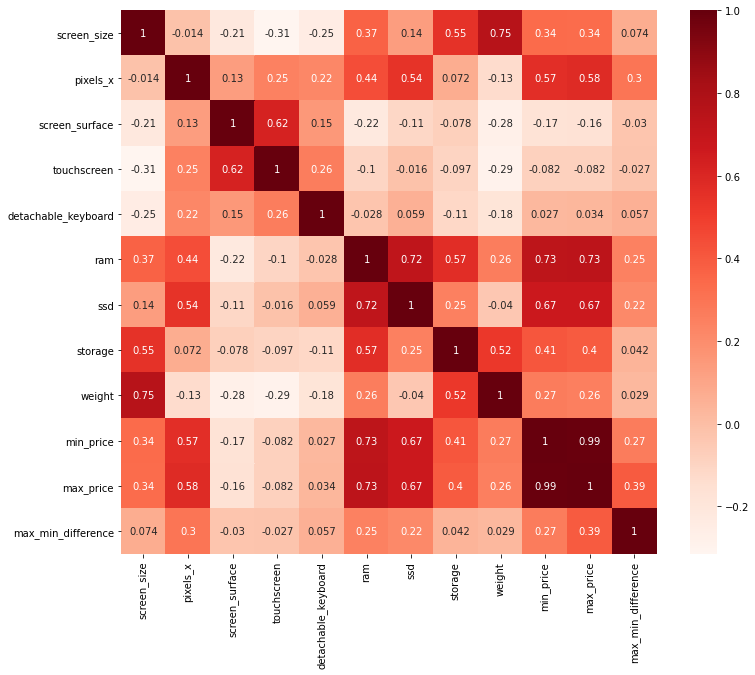

          pixels_x       ram
pixels_x  1.000000  0.440422
ram       0.440422  1.000000
          pixels_x       ssd
pixels_x  1.000000  0.543945
ssd       0.543945  1.000000
          ram       ssd
ram  1.000000  0.719588
ssd  0.719588  1.000000


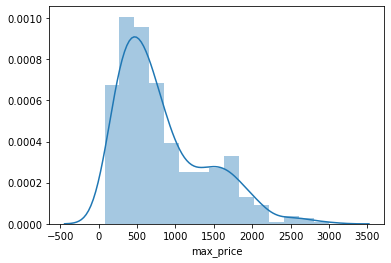

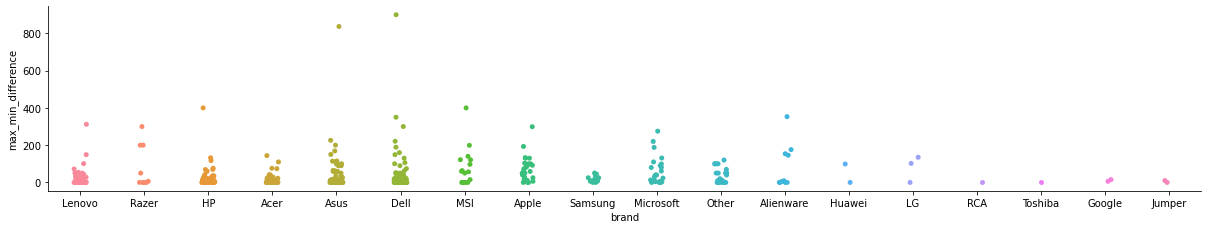

In [21]:
%run "temporary_preprocessing_pipeline.ipynb"

# 1. Load and divide data into train and test set

In [22]:
final_df_train.shape

(508, 97)

In [17]:
# Divide training set into inputs and targets
input_features = final_df_train[final_df_train.columns[:-2]]
targets = final_df_train[final_df_train.columns[-2:]]

# Divide dataset into training, test set and validation set (needs to be adjusted a bit way down)
X_train, X_test, y_train, y_test = train_test_split(input_features, targets, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [18]:
input_features.shape

(508, 95)

# 2. Evaluation functions

In [5]:
 def evaluate_abs_mse(train_rf_predictions,y_train,rf_predictions,y_test): # Pass raw predictions to function
    pred_list_train = train_rf_predictions.tolist()
    target_list_train = y_train.tolist()

    pred_list_test = rf_predictions.tolist()
    target_list_test = y_test.tolist()

    #print(f'Absolute mean square error on training set: {mean_absolute_error(target_list_train, pred_list_train)*2}')
    #print(f'Absolute mean square error on test set: {mean_absolute_error(pred_list_test, target_list_test)*2}')
    return mean_absolute_error(target_list_train, pred_list_train)*2, mean_absolute_error(pred_list_test, target_list_test)*2

# 3. Models

### 3.1. Random forest regressor

In [6]:
# Create model (takes a while)
rfr = RandomForestRegressor(n_estimators= 400,
                            min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features= 'sqrt',
                            max_depth= 75,
                            bootstrap= False,
                            n_jobs=-1,
                            verbose = 0, 
                           criterion='mse')

# Generated best params for new dataset:
#{'n_estimators': 400,
# 'min_samples_split': 2,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': None,
# 'bootstrap': False}

# Train model
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=75, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [8]:
# Get the validation and training performances
trees_number = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 4555]
max_depth_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
min_samples_leaf_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tree_performance_train = []
tree_performance_test = []

for depth in max_depth_list:
    # Train model
    rfr = RandomForestRegressor(n_estimators= 400,
                            min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features= 'sqrt',
                            max_depth= depth,
                            bootstrap= False,
                            n_jobs=-1,
                            verbose = 0, 
                           criterion='mse')
    rfr.fit(X_train,y_train)

    # Test model
    test_rfr_predictions = rfr.predict(X_val)
    train_rfr_predictions = rfr.predict(X_train)

    # Reverse values to original values in euros
    test_rfr_predictions = min_max_scaler_targets.inverse_transform(test_rfr_predictions)
    train_rfr_predictions = min_max_scaler_targets.inverse_transform(train_rfr_predictions)

    y_train_reversed = min_max_scaler_targets.inverse_transform(y_train)
    y_test_reversed = min_max_scaler_targets.inverse_transform(y_val)

    # Get results
    train_performance = 0
    val_performance = 0
    train_performance, val_performance = evaluate_abs_mse(train_rfr_predictions,y_train_reversed,test_rfr_predictions,y_test_reversed)
    tree_performance_train.append(train_performance)
    tree_performance_test.append(val_performance) 

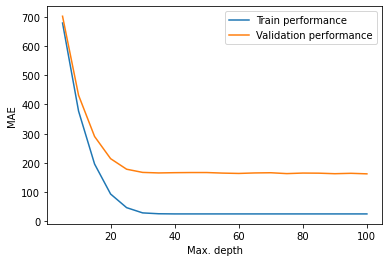

Best performance on training set:  25.68
Best performance on validation set:  162.73
Depth at best performance:  100


In [11]:
# line 1 points
x1 = max_depth_list
y1 = tree_performance_train
# plotting the line 1 points 
plt.plot(x1, y1, label = "Train performance")
# line 2 points
x2 = max_depth_list
y2 = tree_performance_test
# plotting the line 2 points 
plt.plot(x2, y2, label = "Validation performance")
plt.xlabel('Max. depth')
# Set the y axis label of the current axis.
plt.ylabel('MAE')
# Set a title of the current axes.
# plt.title('Model performance with custom features')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

print('Best performance on training set: ', round(min(tree_performance_train), 2))
print('Best performance on validation set: ', round(min(tree_performance_test), 2))
print('Depth at best performance: ', max_depth_list[tree_performance_test.index(min(tree_performance_test))])   

In [7]:
# Model parameter evaluation
n_nodes = []
max_depths = []

for ind_tree in rfr.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 591
Average maximum depth 30


In [6]:
# Test model
test_rfr_predictions = rfr.predict(X_test)
train_rfr_predictions = rfr.predict(X_train)

In [7]:
# Reverse values to original values in euros
test_rfr_predictions = min_max_scaler_targets.inverse_transform(test_rfr_predictions)
train_rfr_predictions = min_max_scaler_targets.inverse_transform(train_rfr_predictions)

y_train_reversed = min_max_scaler_targets.inverse_transform(y_train)
y_test_reversed = min_max_scaler_targets.inverse_transform(y_test)

In [8]:
evaluate_abs_mse(train_rfr_predictions,y_train_reversed,test_rfr_predictions,y_test_reversed)

(28.47873092705753, 159.52851289404424)

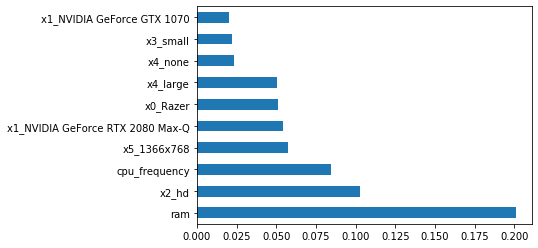

In [9]:
# Post processing (feature importance)
feat_importances = pd.Series(rfr.feature_importances_, index=X_val.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 3.2. Random Forest Regressor for min and max price separately

In [115]:
# targets_min_norm, max_scaler_targets, min_scaler_targets

input_features = final_df_train[final_df_train.columns[:-2]]
targets = pd.concat([targets_max_norm, targets_min_norm], axis = 1)

# Divide dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_features, targets, test_size=0.10, random_state=42)

In [116]:
# Predict max
rfr_max = RandomForestRegressor(n_estimators= 1000,
                            min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features= 'sqrt',
                            max_depth= 110,
                            bootstrap= True,
                            n_jobs=-1,
                            verbose = 0)

rfr_max.fit(X_train,y_train['max_price'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=110, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [117]:
max_prediction = rfr_max.predict(X_test).reshape(-1, 1)
prediction_max = max_scaler_targets.inverse_transform(max_prediction)
y_real_max = max_scaler_targets.inverse_transform(y_test['max_price'].values.reshape(-1, 1))

In [118]:
# Predict min
rfr_min = RandomForestRegressor(n_estimators= 200,
                            min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features= 'sqrt',
                            max_depth= 50,
                            bootstrap= True,
                            n_jobs=-1,
                            verbose = 0)

rfr_min.fit(X_train,y_train['min_price'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [119]:
min_prediction = rfr_min.predict(X_test).reshape(-1, 1)
prediction_min = min_scaler_targets.inverse_transform(min_prediction)
y_real_min = min_scaler_targets.inverse_transform(y_test['min_price'].values.reshape(-1, 1))

In [120]:
for i in range(len(prediction_min)):
    if prediction_max[i] <= prediction_min[i]:
        print('max: ', prediction_max[i], 'min: ', prediction_min[i])

max:  [274.65237857] min:  [281.9255]
max:  [2099.] min:  [2099.]
max:  [1599.99289286] min:  [1621.7325]
max:  [1311.47816667] min:  [1334.565]
max:  [680.55579008] min:  [683.65673214]
max:  [661.7122381] min:  [698.44208333]
max:  [2098.25] min:  [2099.]
max:  [681.85138849] min:  [682.09517262]


In [121]:
full_prediction = pd.concat([pd.DataFrame(prediction_min, columns=['min_price']),
                             pd.DataFrame(prediction_max, columns=['max_price'])], axis=1)

In [122]:
full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['min_price', 'max_price']] = full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['max_price', 'min_price']].values

In [123]:
sum_abs_min_err, sum_abs_max_err = 0, 0

for i in range(len(full_prediction['min_price'])):
    sum_abs_min_err += abs(full_prediction['min_price'][i] - y_real_min[i])
    sum_abs_max_err += abs(full_prediction['max_price'][i] - y_real_max[i])

(sum_abs_min_err + sum_abs_max_err)/(len(full_prediction['min_price']))

array([228.42142136])

In [124]:
y_real_min_df = pd.DataFrame(y_real_min, columns = ['min_price'])
y_real_max_df = pd.DataFrame(y_real_max, columns = ['max_price'])

y_real = pd.concat([y_real_min_df, y_real_max_df], axis=1)

In [125]:
# pd.concat([y_real, full_prediction], axis=1)

# Only for the joint estimation a bit further down
full_prediction_rfr_2 = pd.concat([pd.DataFrame(prediction_min, columns=['min_price']),
                             pd.DataFrame(prediction_max, columns=['max_price'])], axis=1)

### 3.3. Neural network

In [126]:
from sklearn.neural_network import MLPRegressor

In [127]:
# Search for best number of neurons and hidden layers
from random import randint
neurons_and_score = []
for it in range(2, 100):
    p1 = randint(1,100)
    p2 = randint(1,100)
    p3 = randint(1,100)
    
    MLP_estimator = MLPRegressor()
    MLP_estimator.set_params(random_state=42, max_iter=1000, hidden_layer_sizes=(p1, p2, p3),
                            )
    MLP_estimator.fit(X_train, y_train)
    
    # Calculate error
    predictions = MLP_estimator.predict(X_test)
    full_prediction = pd.DataFrame(min_max_scaler_targets.inverse_transform(predictions),columns=['min_price', 'max_price'])
    real_targets = pd.DataFrame(min_max_scaler_targets.inverse_transform(y_test),columns=['min_price', 'max_price'])
    
    sum_abs_min_err, sum_abs_max_err = 0, 0

    for i in range(len(full_prediction['min_price'])):
        sum_abs_min_err += abs(full_prediction['min_price'][i] - real_targets['min_price'][i])
        sum_abs_max_err += abs(full_prediction['max_price'][i] - real_targets['max_price'][i])

    temp_score = (sum_abs_min_err + sum_abs_max_err)/(len(full_prediction['min_price']))
    
    predictions_train = MLP_estimator.predict(X_train)
    full_prediction_train = pd.DataFrame(min_max_scaler_targets.inverse_transform(predictions_train),columns=['min_price', 'max_price'])
    real_targets_train = pd.DataFrame(min_max_scaler_targets.inverse_transform(y_train),columns=['min_price', 'max_price'])
    
    sum_abs_min_err, sum_abs_max_err = 0, 0

    for i in range(len(full_prediction_train['min_price'])):
        sum_abs_min_err += abs(full_prediction_train['min_price'][i] - real_targets_train['min_price'][i])
        sum_abs_max_err += abs(full_prediction_train['max_price'][i] - real_targets_train['max_price'][i])

    temp_score_train = (sum_abs_min_err + sum_abs_max_err)/(len(full_prediction_train['min_price']))
    
    neurons_and_score.append((temp_score, [p1,p2,p3], temp_score_train))

i_temp = (100000, [1,1,1])
for i in neurons_and_score:
    if i[0] < i_temp[0]:
        i_temp = i

print('best params and score: ', i_temp[:2], 'training performance: ', i_temp[2])

# best params and score:  (309.47728680439906, [32, 6, 21])
# best params and score:  (288.0251124357739, [84, 39, 87])
# best params and score:  (262.19035401234345, [26, 80, 69]) training performance:  229.07193412321593

best params and score:  (290.6633593707964, [57, 27, 98]) training performance:  225.55388273849735


In [128]:
MLP_estimator = MLPRegressor()
MLP_estimator.set_params(random_state=42, max_iter=1000, hidden_layer_sizes=(26, 80, 69))

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(26, 80, 69), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [129]:
MLP_estimator.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(26, 80, 69), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [130]:
predictions = MLP_estimator.predict(X_test)
full_prediction_NN = pd.DataFrame(min_max_scaler_targets.inverse_transform(predictions),columns=['min_price', 'max_price'])
real_targets = pd.DataFrame(min_max_scaler_targets.inverse_transform(y_test),columns=['min_price', 'max_price'])

sum_abs_min_err, sum_abs_max_err = 0, 0

for i in range(len(full_prediction_NN['min_price'])):
    sum_abs_min_err += abs(full_prediction_NN['min_price'][i] - real_targets['min_price'][i])
    sum_abs_max_err += abs(full_prediction_NN['max_price'][i] - real_targets['max_price'][i])

temp_score = (sum_abs_min_err + sum_abs_max_err)/(len(full_prediction_NN['min_price']))
temp_score

393.9233413672051

In [5]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

rfr_max = AdaBoostRegressor(DecisionTreeRegressor(min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features= 'sqrt',
                            max_depth= 30,
                           criterion='mse'),
                          n_estimators=500, random_state=42)

rfr_max.fit(X_train,y_train['max_price'])

rfr_min = AdaBoostRegressor(DecisionTreeRegressor(min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features= 'sqrt',
                            max_depth= 30,
                           criterion='mse'),
                          n_estimators=500, random_state=42)

rfr_min.fit(X_train,y_train['min_price'])

max_prediction = rfr_max.predict(X_test).reshape(-1, 1)
prediction_max = max_scaler_targets.inverse_transform(max_prediction)
y_real_max = max_scaler_targets.inverse_transform(y_test['max_price'].values.reshape(-1, 1))

min_prediction = rfr_min.predict(X_test).reshape(-1, 1)
prediction_min = min_scaler_targets.inverse_transform(min_prediction)
y_real_min = min_scaler_targets.inverse_transform(y_test['min_price'].values.reshape(-1, 1))


full_prediction = pd.concat([pd.DataFrame(prediction_min, columns=['min_price']),
                             pd.DataFrame(prediction_max, columns=['max_price'])], axis=1)

full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['min_price', 'max_price']] = full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['max_price', 'min_price']].values

sum_abs_min_err, sum_abs_max_err = 0, 0

for i in range(len(full_prediction['min_price'])):
    sum_abs_min_err += abs(full_prediction['min_price'][i] - y_real_min[i])
    sum_abs_max_err += abs(full_prediction['max_price'][i] - y_real_max[i])

(sum_abs_min_err + sum_abs_max_err)/(len(full_prediction['min_price']))

array([215.87477061])

In [6]:
# Official prediction of hidden dataset
max_prediction = rfr_max.predict(final_df_test).reshape(-1, 1)
prediction_max = max_scaler_targets.inverse_transform(max_prediction)
y_real_max = max_scaler_targets.inverse_transform(y_test['max_price'].values.reshape(-1, 1))

min_prediction = rfr_min.predict(final_df_test).reshape(-1, 1)
prediction_min = min_scaler_targets.inverse_transform(min_prediction)
y_real_min = min_scaler_targets.inverse_transform(y_test['min_price'].values.reshape(-1, 1))


full_prediction = pd.concat([pd.DataFrame(prediction_min, columns=['min_price']),
                             pd.DataFrame(prediction_max, columns=['max_price'])], axis=1)

full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['min_price', 'max_price']] = full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['max_price', 'min_price']].values

submission_multi_rfr_new = pd.concat([pd.DataFrame(df_laptops_test['id']), full_prediction], axis=1)
submission_multi_rfr_new

,id,min_price,max_price
0,28807,1099.000000,1119.278459
1,22559,568.000000,629.000000
2,28647,661.000000,799.000000
3,22141,693.000000,749.000000
4,26116,2149.000000,2149.000000
...,...,...,...
217,8398,1059.083481,1060.744308
218,21211,1199.000000,1379.000000
219,22553,2693.000000,2699.000000
220,28808,888.000000,896.000000


In [43]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(input_features, targets, test_size=0.3, random_state=42)
dtrain_max = xgb.DMatrix(X_train, label=y_train['max_price'])
dtest_max = xgb.DMatrix(X_test, label=y_test['max_price'])

dtrain_min = xgb.DMatrix(X_train, label=y_train['min_price'])
dtest_min = xgb.DMatrix(X_test, label=y_test['min_price'])


param = {'max_depth': 400, 'objective': 'reg:gamma', 'verbosity':0}
param['eval_metric'] = 'mae'
evallist_max = [(dtest_max, 'eval'), (dtrain_max, 'train')]
evallist_min = [(dtest_min, 'eval'), (dtrain_min, 'train')]

num_round = 27
bst_max = xgb.train(param, dtrain_max, num_round)
bst_min = xgb.train(param, dtrain_min, num_round)

In [44]:
max_prediction = bst_max.predict(dtest).reshape(-1, 1)
prediction_max = max_scaler_targets.inverse_transform(max_prediction)
y_real_max = max_scaler_targets.inverse_transform(y_test['max_price'].values.reshape(-1, 1))

min_prediction = bst_min.predict(dtest).reshape(-1, 1)
prediction_min = min_scaler_targets.inverse_transform(min_prediction)
y_real_min = min_scaler_targets.inverse_transform(y_test['min_price'].values.reshape(-1, 1))

In [45]:
full_prediction = pd.concat([pd.DataFrame(prediction_min, columns=['min_price']),
                             pd.DataFrame(prediction_max, columns=['max_price'])], axis=1)

full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['min_price', 'max_price']] = full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['max_price', 'min_price']].values

sum_abs_min_err, sum_abs_max_err = 0, 0

for i in range(len(full_prediction['min_price'])):
    sum_abs_min_err += abs(full_prediction['min_price'][i] - y_real_min[i])
    sum_abs_max_err += abs(full_prediction['max_price'][i] - y_real_max[i])

(sum_abs_min_err + sum_abs_max_err)/(len(full_prediction['min_price']))

array([135.31633518])

In [41]:
# Official prediction of hidden dataset
xgb_test_set = xgb.DMatrix(final_df_test)

max_prediction = bst_max.predict(xgb_test_set).reshape(-1, 1)
prediction_max = max_scaler_targets.inverse_transform(max_prediction)

min_prediction = bst_min.predict(xgb_test_set).reshape(-1, 1)
prediction_min = min_scaler_targets.inverse_transform(min_prediction)


full_prediction = pd.concat([pd.DataFrame(prediction_min, columns=['min_price']),
                             pd.DataFrame(prediction_max, columns=['max_price'])], axis=1)

full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['min_price', 'max_price']] = full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['max_price', 'min_price']].values

submission_multi_rfr_new = pd.concat([pd.DataFrame(df_laptops_test['id']), full_prediction], axis=1)
submission_multi_rfr_new

,id,min_price,max_price
0,28807,1074.760010,1143.742554
1,22559,370.367432,389.518219
2,28647,749.129822,784.461548
3,22141,531.770020,546.359253
4,26116,2393.961182,2624.152344
...,...,...,...
217,8398,746.832458,783.605042
218,21211,1041.781860,1163.940918
219,22553,2027.441284,2345.219482
220,28808,837.025452,895.584656


## 4. Test models on real test data

In [27]:
# rfr predictions
final_prediction = min_max_scaler_targets.inverse_transform(rfr.predict(final_df_test))

submission_prices = pd.DataFrame(final_prediction, columns = ['min_price', 'max_price']) 
submission_multi_rfr_new = pd.concat([pd.DataFrame(df_laptops_test['id']), submission_prices], axis=1)

In [28]:
# Write final df to csv
submission_multi_rfr_new.to_csv(r'../../submission/models_rfr_submission_15.csv', index = False)

## ------------------------------ Unimportant -------------------------------

In [167]:
# rfr_2 predictions
max_prediction_final = rfr_max.predict(final_df_test).reshape(-1, 1)
prediction_max_final = max_scaler_targets.inverse_transform(max_prediction_final)

min_prediction_final = rfr_min.predict(final_df_test).reshape(-1, 1)
prediction_min_final = min_scaler_targets.inverse_transform(min_prediction_final)

prediction_max_final_df = pd.DataFrame(prediction_max_final, columns = ['max_price']) 
prediction_min_final_df = pd.DataFrame(prediction_min_final, columns = ['min_price']) 

submission_prices = pd.concat([prediction_min_final_df, prediction_max_final_df], axis=1) 
submission_singles = pd.concat([pd.DataFrame(df_laptops_test['id']), submission_prices], axis=1)

In [168]:
# Check whether no min > max
for i in range(len(prediction_max_final)):
    if prediction_max_final[i] <= prediction_min_final[i]:
        print('max: ', prediction_max_final[i], 'min: ', prediction_min_final[i])

max:  [182.57073333] min:  [183.30741667]
max:  [380.78531389] min:  [388.99925]
max:  [356.56574841] min:  [359.10808333]
max:  [433.477457] min:  [437.80075108]
max:  [2251.195] min:  [2292.99]
max:  [1580.52224729] min:  [1608.5967734]
max:  [768.91426667] min:  [778.75333333]
max:  [365.886] min:  [370.13583333]
max:  [671.79674762] min:  [673.37833333]
max:  [1397.64579881] min:  [1509.29416667]
max:  [516.78555357] min:  [519.53513095]
max:  [1190.453] min:  [1194.755]
max:  [487.12035516] min:  [504.87767857]
max:  [1224.05458333] min:  [1224.67166667]
max:  [1078.6695] min:  [1113.32833333]
max:  [755.2718381] min:  [760.12567857]
max:  [755.2718381] min:  [760.12567857]
max:  [752.87400476] min:  [757.43458333]
max:  [751.48963333] min:  [757.5275]
max:  [379.83930397] min:  [380.80406854]
max:  [466.41729048] min:  [475.50486111]
max:  [344.59358764] min:  [347.024]
max:  [1288.55262143] min:  [1322.70875]
max:  [557.27232143] min:  [560.40094444]
max:  [610.9952881] min:  [6

In [169]:
# Turn those wrong predictions 
submission_singles.loc[submission_singles['min_price'] > submission_singles['max_price'], ['min_price', 'max_price']] = submission_singles.loc[submission_singles['min_price'] > submission_singles['max_price'], ['max_price', 'min_price']].values

In [170]:
# ANN predictions
final_prediction = min_max_scaler_targets.inverse_transform(MLP_estimator.predict(final_df_test))

submission_prices = pd.DataFrame(final_prediction, columns = ['min_price', 'max_price']) 
submission_multi_NN = pd.concat([pd.DataFrame(df_laptops_test['id']), submission_prices], axis=1)

# To be sure: turn the wrongly predicted max and min prices
submission_multi_NN.loc[submission_multi_NN['min_price'] > submission_multi_NN['max_price'], ['min_price', 'max_price']] = submission_multi_NN.loc[submission_multi_NN['min_price'] > submission_multi_NN['max_price'], ['max_price', 'min_price']].values

In [171]:
# Test the manually made ensemble
average_prediction_min = (submission_multi_rfr['min_price'] + submission_singles['min_price'] + submission_multi_NN['min_price'])/3
average_prediction_max = (submission_multi_rfr['max_price'] + submission_singles['max_price'] + submission_multi_NN['max_price'])/3

In [175]:
full_pred_group_test = pd.concat([df_laptops_test['id'], average_prediction_min, average_prediction_max], axis=1)

In [30]:
# Write final df to csv
submission_multi_rfr_new.to_csv(r'../../submission/models_rfr_submission_13.csv', index = False)

# Model experimentation (not important)

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 10000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 2, 3]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

criterions = ['mse', 'mae']
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 2, 3],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 1288, 2377, 3466, 4555, 5644, 6733, 7822, 8911, 10000]}


In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr3 = RandomForestRegressor(criterion='mse')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfr3, param_distributions = random_grid, n_iter = 120, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 44.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [29]:
rf_random.best_params_

{'n_estimators': 4555,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 2,
 'max_depth': None,
 'bootstrap': False}

## MAX RFR

In [70]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [71]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr_max = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfr_max, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train['max_price'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [72]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

## MIN RFR

In [73]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [74]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr3_min = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfr3_min, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train['min_price'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [75]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}